# Modèle pre-entrainer VGG16 : classification binaire COVID / SAIN (NORMAL) par extraction de features

In [2]:
# Chargement des modules necessaire :

import os

import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Model


In [3]:
# On declare les chemins vers les donnees :

trainDir = 'Data/TRAIN'
validationDir = 'Data/TEST'
 
# On declare les dimensions pour les images (224,224) :
img_width, img_height = 224, 224

# On liste et stocke les chemins des images :
ImageTRAINCOVID = os.listdir(trainDir + '/COVID')
ImageTRAINNORMAL = os.listdir(trainDir + '/NORMAL')

ImageTESTCOVID = os.listdir(validationDir + '/COVID')
ImageTESTNORMAL = os.listdir(validationDir + '/NORMAL')

# On affiche le nombre d'image trouve :
print('Il y a ' + str(len(ImageTRAINCOVID)) + ' images d\'entrainement de patient covid.') 
print('Il y a ' + str(len(ImageTRAINNORMAL)) + ' images d\'entrainement de patient non-covid.') 
print('Il y a ' + str(len(ImageTESTCOVID)) + ' images test de patient covid.') 
print('Il y a ' + str(len(ImageTESTNORMAL)) + ' images test de patient non-covid.')


Il y a 401 images d'entrainement de patient covid.
Il y a 401 images d'entrainement de patient non-covid.
Il y a 101 images test de patient covid.
Il y a 101 images test de patient non-covid.


TRAIN COVID


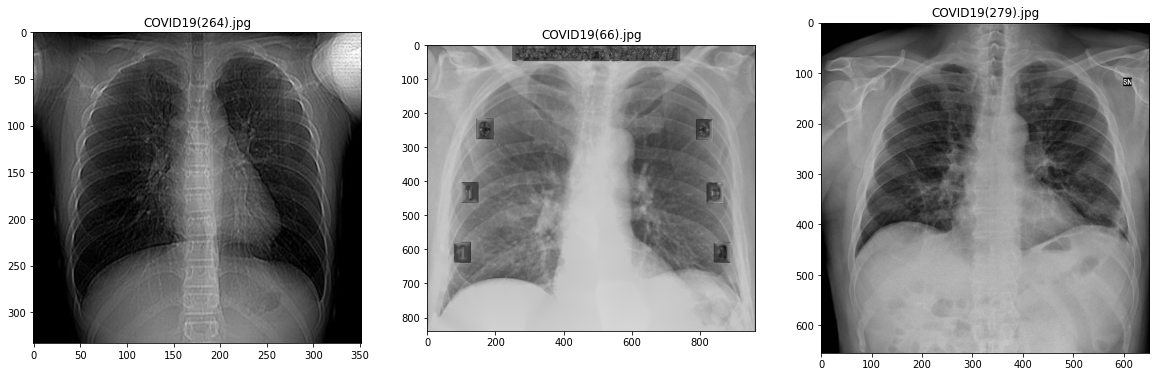

TEST COVID


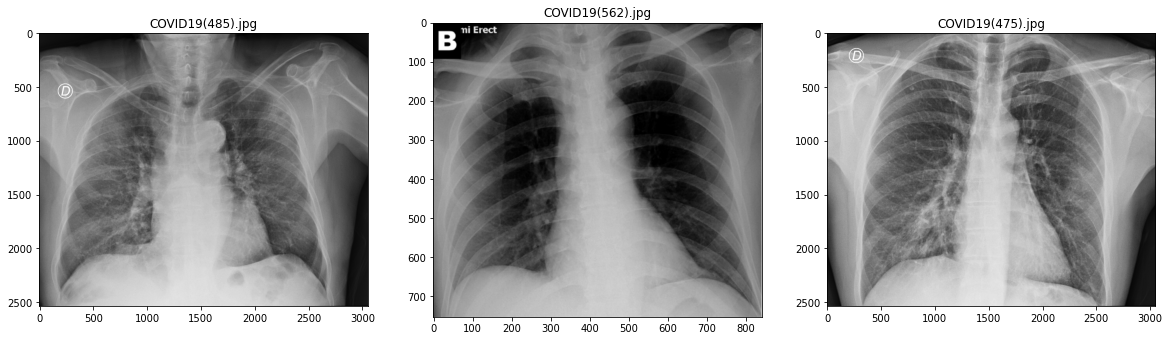

TRAIN NORMAL


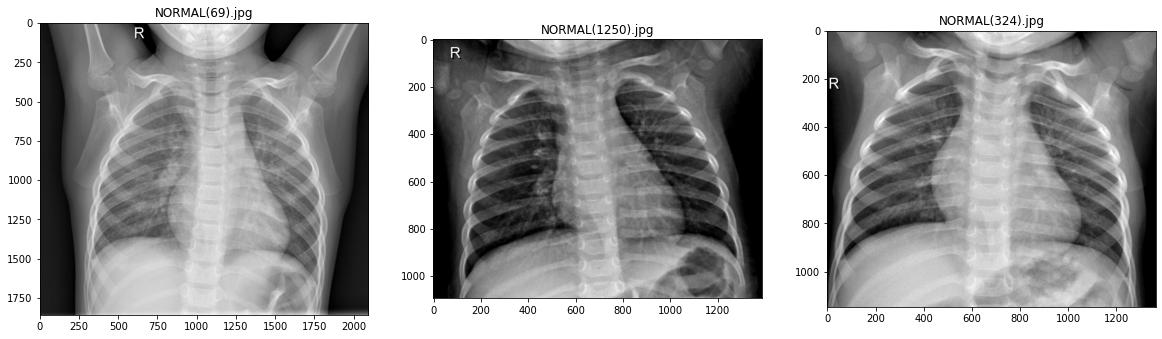

TEST NORMAL


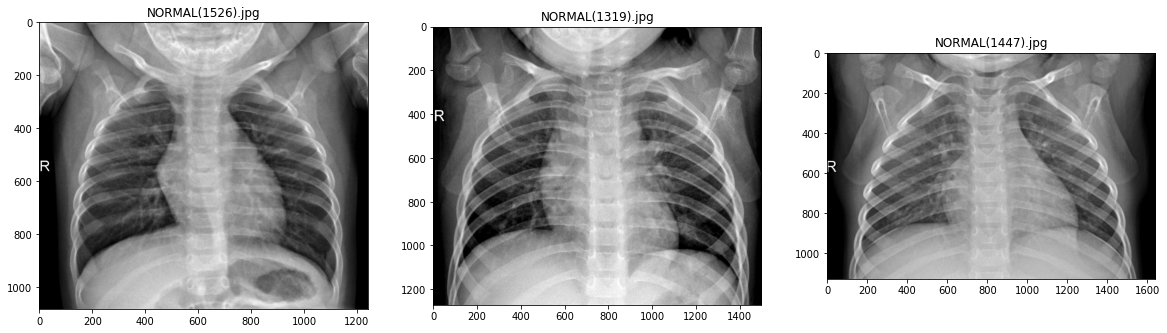

In [6]:
# Visualisation de 6 exemples en 2 lignes et 3 colonnes pour chaque classe :

# Visualisation de 6 exemples en 2 lignes et 3 colonnes pour chaque classe :

# TRAIN :

print("TRAIN COVID")


# COVID  :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINCOVID = random.choice(os.listdir(trainDir + '/COVID'))
    plt.imshow(plt.imread(os.path.join( trainDir +'/COVID',randomImageTRAINCOVID)), cmap='gray')
    plt.title(randomImageTRAINCOVID)
    
plt.show()

print("TEST COVID")
# COVID  :
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTCOVID = random.choice(os.listdir(validationDir + '/COVID'))
    plt.imshow(plt.imread(os.path.join( validationDir +'/COVID',randomImageTESTCOVID)), cmap='gray')
    plt.title(randomImageTESTCOVID)
    
plt.show()

print("TRAIN NORMAL")
# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINNORMAL = random.choice(os.listdir(trainDir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join( trainDir +'/NORMAL',randomImageTRAINNORMAL)), cmap='gray')
    plt.title(randomImageTRAINNORMAL)
    
plt.show()


# TEST:

print("TEST NORMAL")

# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTNORMAL = random.choice(os.listdir(validationDir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join(validationDir +'/NORMAL',randomImageTESTNORMAL)), cmap='gray')
    plt.title(randomImageTESTNORMAL)
    
plt.show()

In [7]:
# Preprocessing :
# On rescale les images :
datagen = ImageDataGenerator(rescale=1./255)

# On definit la batch size :
batch_size = 32

# On prepare les tableaux de donnees depuis les images :
train_generator_bottleneck = datagen.flow_from_directory(
        trainDir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validationDir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None)



Found 1726 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


In [8]:
# Chargement de VGG16 sans la partie fully-connected avec le reseau convolutif entrainer sur imagenet :

model_vgg = applications.VGG16(include_top=False, weights='imagenet')

In [ ]:
# On utilse le model VGG16 pour extraire les features de nos images 
# (on fait recupere la sortie du reseau convolutionnel) :
train_features = model_vgg.predict_generator(train_generator_bottleneck, 1726 // batch_size)

validation_features = model_vgg.predict_generator(validation_generator_bottleneck, 433 // batch_size)

# L'opération étant longue on enregistre les features obtenus :
np.save(open('models/trainFeatures_VGG16_AllData.npy', 'wb'), train_features) # ecriture en binaire necessaire
np.save(open('models/validationFeatures_VGG16_AllData.npy', 'wb'), validation_features) # Idem

In [4]:
# Si l'operation à deja été effectuer on charge les features :

train_features = np.load(open('models/trainFeatures_VGG16_AllData.npy', 'rb'))

validation_features = np.load(open('models/validationFeatures_VGG16_AllData.npy', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'models/trainFeatures_VGG16_AllData.npy'

In [10]:
# On definit les labels :

train_labels = np.array([0] * 448 + [1] * 1248)

validation_labels = np.array([0] * 116 + [1] * 300)

# On peut maintenant tester plusieurs couches fully-connected à partir de ce modele :

In [11]:
# Premier modele : 
model_top1 = Sequential()
model_top1.add(Flatten(input_shape=train_features.shape[1:]))
model_top1.add(Dense(64, activation='relu'))
model_top1.add(Dropout(0.5))
model_top1.add(Dense(1, activation='sigmoid'))

# On compile :
model_top1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,605,761
Trainable params: 1,605,761
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Second modele :
model_top2 = Sequential()
model_top2.add(Flatten(input_shape=train_features.shape[1:]))
model_top2.add(Dense(128, activation='relu'))
model_top2.add(Dropout(0.5))
model_top2.add(Dense(1, activation='sigmoid'))

# On compile :
model_top2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,211,521
Trainable params: 3,211,521
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Troisieme modele :
model_top3 = Sequential()
model_top3.add(Flatten(input_shape=train_features.shape[1:]))
model_top3.add(Dense(256, activation='relu'))
model_top3.add(Dropout(0.5))
model_top3.add(Dense(1, activation='sigmoid'))

# On compile :
model_top3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [14]:
# On definit les parametres pour l'entrainement :
epochs = 100


# On definit les callbacks : 
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience = 10,restore_best_weights=True,),
]

In [15]:
# On entraine le premier modèle:

historique1 = model_top1.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
53/53 [==============================] - 2s 28ms/step - loss: 1.0173 - accuracy: 0.8182 - val_loss: 0.2129 - val_accuracy: 0.9279
Epoch 2/10
53/53 [==============================] - 1s 23ms/step - loss: 0.2320 - accuracy: 0.9274 - val_loss: 0.0699 - val_accuracy: 0.9904
Epoch 3/10
53/53 [==============================] - 1s 23ms/step - loss: 0.1165 - accuracy: 0.9642 - val_loss: 0.0748 - val_accuracy: 0.9663
Epoch 4/10
53/53 [==============================] - 1s 24ms/step - loss: 0.1203 - accuracy: 0.9664 - val_loss: 0.1725 - val_accuracy: 0.9423
Epoch 5/10
53/53 [==============================] - 1s 25ms/step - loss: 0.0926 - accuracy: 0.9727 - val_loss: 0.0251 - val_accuracy: 0.9952
Epoch 6/10
53/53 [==============================] - 1s 24ms/step - loss: 0.0789 - accuracy: 0.9845 - val_loss: 0.0251 - val_accuracy: 0.9952
Epoch 7/10
53/53 [==============================] - 1s 23ms/step - loss: 0.0998 - accuracy: 0.9765 - val_loss: 0.0126 - val_accuracy: 0.9952
Epoch 8/10
53

In [ ]:
n_epochs = len(historique1.history['loss'])
print("la generation optimale est : ",n_epochs-10)

In [16]:
# On entraine le deuxième modèle:
historique2 = model_top2.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
53/53 [==============================] - 3s 39ms/step - loss: 1.1151 - accuracy: 0.8812 - val_loss: 0.0195 - val_accuracy: 0.9952
Epoch 2/10
53/53 [==============================] - 2s 47ms/step - loss: 0.0714 - accuracy: 0.9797 - val_loss: 0.1215 - val_accuracy: 0.9543
Epoch 3/10
53/53 [==============================] - 2s 43ms/step - loss: 0.1026 - accuracy: 0.9745 - val_loss: 0.0083 - val_accuracy: 0.9976
Epoch 4/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0753 - accuracy: 0.9815 - val_loss: 0.2137 - val_accuracy: 0.9351
Epoch 5/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0827 - accuracy: 0.9732 - val_loss: 0.0057 - val_accuracy: 0.9976
Epoch 6/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0534 - accuracy: 0.9853 - val_loss: 0.0061 - val_accuracy: 0.9976
Epoch 7/10
53/53 [==============================] - 2s 42ms/step - loss: 0.0741 - accuracy: 0.9823 - val_loss: 0.0131 - val_accuracy: 0.9928
Epoch 8/10
53

In [ ]:
n_epochs = len(historique2.history['loss'])
print("la generation optimale est : ",n_epochs-10)

In [17]:
# On entraine le troisième modèle:
historique3 = model_top3.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
53/53 [==============================] - 4s 74ms/step - loss: 2.3064 - accuracy: 0.8382 - val_loss: 0.0436 - val_accuracy: 0.9856
Epoch 2/10
53/53 [==============================] - 4s 75ms/step - loss: 0.0964 - accuracy: 0.9804 - val_loss: 0.0659 - val_accuracy: 0.9736
Epoch 3/10
53/53 [==============================] - 4s 77ms/step - loss: 0.0914 - accuracy: 0.9725 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/10
53/53 [==============================] - 5s 86ms/step - loss: 0.0633 - accuracy: 0.9836 - val_loss: 0.0140 - val_accuracy: 0.9952
Epoch 5/10
53/53 [==============================] - 6s 112ms/step - loss: 0.0706 - accuracy: 0.9787 - val_loss: 0.1041 - val_accuracy: 0.9615
Epoch 6/10
53/53 [==============================] - 5s 93ms/step - loss: 0.0807 - accuracy: 0.9796 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 7/10
53/53 [==============================] - 4s 78ms/step - loss: 0.0603 - accuracy: 0.9880 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 8/10
5

In [ ]:
n_epochs = len(historique3.history['loss'])
print("la generation optimale est : ",n_epochs-10)

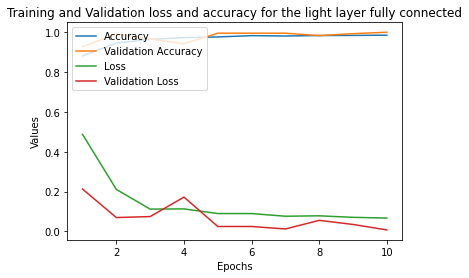

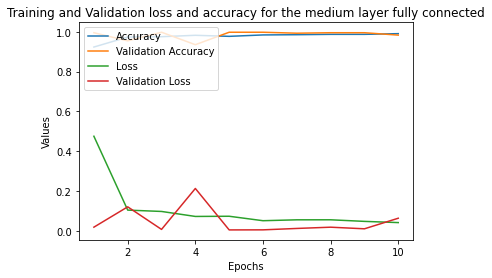

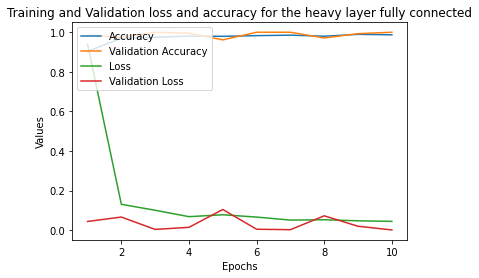

In [21]:
# Visualisation de l'entrainement :

epochs = range(1,11)
plt.plot(epochs, historique1.history['accuracy'], label='Accuracy')
plt.plot(epochs, historique1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, historique1.history['loss'], label='Loss')
plt.plot(epochs, historique1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the light layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()


epochs = range(1,11)
plt.plot(epochs, historique2.history['accuracy'], label='Accuracy')
plt.plot(epochs, historique2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, historique2.history['loss'], label='Loss')
plt.plot(epochs, historique2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the medium layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()


epochs = range(1,11)
plt.plot(epochs, historique3.history['accuracy'], label='Accuracy')
plt.plot(epochs, historique3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, historique3.history['loss'], label='Loss')
plt.plot(epochs, historique3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the heavy layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()


In [19]:
# On evalue :

# Avec les donnes de validation :
eval1 = model_top1.evaluate(validation_features, validation_labels,verbose=2)
eval2 = model_top2.evaluate(validation_features, validation_labels,verbose=2)
eval3 = model_top3.evaluate(validation_features, validation_labels,verbose=2)

# Avec les donnes de test :

    # A ajouter

# On prend quelques exemples aleatoires :

    # on visualise, on test , on affiche :
    
    # => Chourouk

13/13 - 0s - loss: 0.0079 - accuracy: 1.0000
13/13 - 0s - loss: 0.0644 - accuracy: 0.9832
13/13 - 0s - loss: 8.8200e-04 - accuracy: 1.0000


## Enregistrements (facultatif)

In [20]:
# On enregistre les historiques du modèles:

np.save('../memory/history/historique_chourouk_vgg16_224_224_light_10G.npy',historique1.history)
np.save('../memory/history/historique_chourouk_vgg16_224_224_medium_10G.npy',historique2.history)
np.save('../memory/history/historique_chourouk_vgg16_224_224_heavy_10G.npy',historique3.history)

In [ ]:
# On enregistre les poids du modèles :
model_top1.save_weights('../memory/Weights/vgg16_lightTop_224_224_10G.h5')
model_top2.save_weights('../memory/Weights/vgg16_mediumTop_224_224_10G.h5')
model_top3.save_weights('../memory/Weights/vgg16_heavyTop_224_224_10G.h5')

In [ ]:
#On enregistre les modèles:
model_top1.save("../memory/FullModels/vgg16_lightTop_224_224_10G")
model_top2.save("../memory/FullModels/vgg16_mediumTop_224_224_10G")
model_top3.save("../memory/FullModels/vgg16_heavyTop_224_224_10G")